## Homework №2

### Almost Shakespeare

Let's try to generate some Shakespeare poetry using RNNs. The sonnets file is available in the notebook directory.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


### Data loading

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`).

Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [1]:
import string
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os

In [2]:
try:
    with open('../../datasets/Shakespeare_sonnets/sonnets.txt', 'r') as iofile:
        text = iofile.readlines()
except FileNotFoundError:
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Shakespeare_sonnets/sonnets.txt -nc
    with open('sonnets.txt', 'r') as iofile:
        text = iofile.readlines()

File ‘sonnets.txt’ already there; not retrieving.



In [3]:
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [4]:
# Join all the strings into one and lowercase it

# Put result into variable text.
text = "".join(text).lower()

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


Put all the characters, that you've seen in the text, into variable `tokens`.

In [5]:
tokens = sorted(set(text))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [6]:
# dict <index>:<char>
# dict <char>:<index>
token_to_idx = {}
idx_to_token = {}
for idx,token in enumerate(tokens, start = 0):
    token_to_idx[token] = idx
    idx_to_token[idx] = token

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [7]:
def to_matrix(names, max_len=None, pad=token_to_idx[' '], dtype='int32', batch_first = True):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, names))
    names_ix = np.zeros([len(names), max_len], dtype) + pad

    for i in range(len(names)):
        line_ix = [token_to_idx[c] for c in names[i]]
        names_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        names_ix = np.transpose(names_ix)

    return names_ix

In [8]:
import torch, torch.nn as nn
import torch.nn.functional as F

# Vanilla RNN Model
class CharRNNCell_Vanilla(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, containing vector of int64
        :param h_prev: previous rnn hidden states, containing matrix [batch, rnn_num_units] of float32
        """
        # get vector embedding of x
        x_emb = self.embedding(x)
        
        # compute next hidden state using self.rnn_update
        # hint: use torch.cat(..., dim=...) for concatenation
        x_and_h = torch.cat([x_emb, h_prev], dim=1) # YOUR CODE HERE
        h_next = self.rnn_update(x_and_h) # YOUR CODE HERE
        
        h_next = torch.tanh(h_next) # YOUR CODE HERE
        
        assert h_next.size() == h_prev.size()
        
        #compute logits for next character probs
        logits = self.rnn_to_logits(h_next)# YOUR CODE
        
        return h_next, F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(batch_size, self.num_units, requires_grad=True)

In [9]:
def rnn_loop(char_rnn, batch_ix):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_ix.transpose(0,1):
        hid_state, logp_next = char_rnn(x_t, hid_state)
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

In [10]:
class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, embedding_size)
        self.rnn = nn.RNN(embedding_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x):
        assert isinstance(x.data, torch.LongTensor)
        h_seq, _ = self.rnn(self.emb(x))
        logits = self.hid_to_logits(h_seq)    
        return F.log_softmax(logits, -1)

In [11]:
# Prepare data
import re
text_splitString = text.split('\n')
text_splitDoubleString = ["".join(text_splitString[i-2:i]) for i in range(2,len(text_splitString),2)]
text_splitFourString = ["".join(text_splitString[i-4:i]) for i in range(4,len(text_splitString),4)]
# split by chapter
text_splitChapter = re.split("\n\n\s{1,}\w{1,10}\n\n",text)

#  Prepare Tensors
MAX_LENGTH = max(map(len, text_splitString))
temp = to_matrix(text_splitString, max_len=MAX_LENGTH)
text_splitString_torch = torch.tensor(temp, dtype=torch.int64)

MAX_LENGTH = max(map(len, text_splitDoubleString))
temp = to_matrix(text_splitDoubleString, max_len=MAX_LENGTH)
text_splitDoubleString_torch = torch.tensor(temp, dtype=torch.int64)

MAX_LENGTH = max(map(len, text_splitFourString))
temp = to_matrix(text_splitFourString, max_len=MAX_LENGTH)
text_splitFourString_torch = torch.tensor(temp, dtype=torch.int64)

MAX_LENGTH = max(map(len, text_splitChapter))
temp = to_matrix(text_splitChapter, max_len=MAX_LENGTH)
text_splitChapter_torch = torch.tensor(temp, dtype=torch.int64)


In [12]:
from IPython.display import clear_output
def train_modelRNN(
    modelRNN,    
    opt,
    train_torch,
    criterion,
    count_tokens,
    n_iterations=1000,
    batch_size=32,
    #warm_start=False,
    show_plots=True,
    #eval_every=10
    exist_loop=False,
    
):    
    history = []
    for i in range(n_iterations):        
        ix = np.random.randint(0, len(train_torch), batch_size)
        batch_ix = train_torch[ix]

        if not exist_loop:
            logp_seq = rnn_loop(modelRNN, batch_ix)
        else:
            logp_seq = modelRNN(batch_ix)
                

        # compute loss
        predictions_logp = logp_seq[:, :-1]# YOUR CODE HERE
        actual_next_tokens = batch_ix[:, 1:]# YOUR CODE HERE

        loss = criterion(
            predictions_logp.contiguous().view(-1, count_tokens),
            actual_next_tokens.contiguous().view(-1)
        ) # YOUR CODE HERE

        # train with backprop
        loss.backward()
        opt.step()
        opt.zero_grad()
        # YOUR CODE HERE

        history.append(loss.data.numpy())
        if show_plots:
            if (i+1)%100==0:
                clear_output(True)
                plt.plot(history,label='loss')
                plt.legend()
                plt.show()

    assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."    
    

In [13]:
def generate_sample(char_rnn, max_length, tokens,token_to_idx, seed_phrase=' hello', temperature=1.0, exist_loop=False):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''    
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)

    
    if not exist_loop:
        hid_state = char_rnn.initial_state(batch_size=1)

        #feed the seed phrase, if any
        for i in range(len(seed_phrase) - 1):
            #print(x_sequence,x_sequence[:, -1].shape, hid_state.shape)
            hid_state, out  = char_rnn(x_sequence[:, i], hid_state)


        #start generating
        for _ in range(max_length - len(seed_phrase)):
            #print(x_sequence.shape, x_sequence, hid_state.shape)
            hid_state, out = char_rnn(x_sequence[:, -1], hid_state)
            # Be really careful here with the model output
            p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0]
            # sample next token and push it back into x_sequence
            #print(p_next.shape, len(tokens))
            next_ix = np.random.choice(len(tokens), p=p_next)
            next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
            #print(x_sequence.shape, next_ix.shape)
            x_sequence = torch.cat([x_sequence, next_ix], dim=1)

        return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])
    else:
        # for nn.RNN ...
        #_ = char_rnn(x_sequence[:, :-1])
        #start generating
        for _ in range(max_length - len(seed_phrase)):
            #print(x_sequence.shape, x_sequence, hid_state.shape)
            #out = char_rnn(x_sequence[:, -1:])
            out = char_rnn(x_sequence)
            # Be really careful here with the model output
            p_next = F.softmax(out[:,-1,:] / temperature, dim=-1).data.numpy()[0]
            # sample next token and push it back into x_sequence
            #print(p_next.shape, len(tokens))
            next_ix = np.random.choice(len(tokens), p=p_next)
            next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
            #print(x_sequence.shape, next_ix.shape)
            x_sequence = torch.cat([x_sequence, next_ix], dim=1)

        return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [14]:
x_sequence = [token_to_idx[token] for token in "nice"]
x_sequence = torch.tensor([x_sequence], dtype=torch.int64)


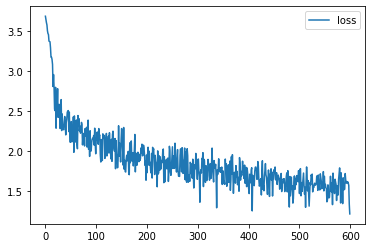

In [15]:
# Your plot here
char_rnn_vanilla = CharRNNCell_Vanilla(num_tokens=len(tokens), embedding_size=16, rnn_num_units=64)
criterion = nn.NLLLoss()
opt = torch.optim.Adam(char_rnn_vanilla.parameters())
train_modelRNN(char_rnn_vanilla, opt, text_splitFourString_torch, criterion,len(tokens), n_iterations=600, batch_size=16, exist_loop=False)

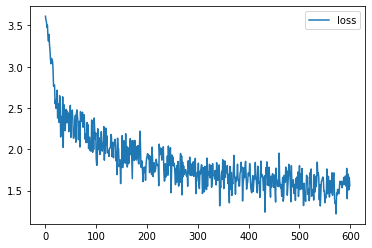

In [16]:
# use nn.RNN
char_rnn_torch = CharRNNLoop()
criterion_torch = nn.NLLLoss()
opt_torch = torch.optim.Adam(char_rnn_torch.parameters())
train_modelRNN(char_rnn_torch, opt_torch, text_splitFourString_torch, criterion_torch,len(tokens), n_iterations=600, batch_size=16, exist_loop=True)

In [49]:
# An example of generated text.
print(generate_sample(char_rnn_vanilla,100,tokens,token_to_idx, seed_phrase="love ", temperature=0.5, exist_loop=False))

love then ther that  the the me the or love,                                                        


In [50]:
print(generate_sample(char_rnn_torch,100 ,tokens,token_to_idx, seed_phrase="love ",temperature=0.5, exist_loop=True))

love the that an thou sthe  thou seat thou the thin that and hour saut in the that the thare        


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [19]:
class CharLSTMLoop(nn.Module):
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, embedding_size)
        self.lstm = nn.LSTM(embedding_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x):
        assert isinstance(x.data, torch.LongTensor)
        h_seq, _ = self.lstm(self.emb(x))
        logits = self.hid_to_logits(h_seq)    
        return F.log_softmax(logits, -1)

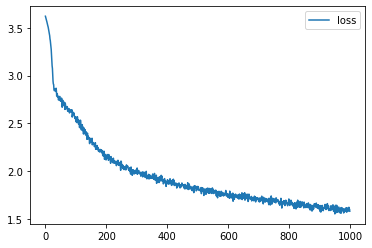

In [20]:
char_lstm_torch = CharLSTMLoop()
criterion_lstm_torch = nn.NLLLoss()
opt_lstm_torch = torch.optim.Adam(char_lstm_torch.parameters())
train_modelRNN(char_lstm_torch, opt_lstm_torch, text_splitChapter_torch, criterion_lstm_torch,len(tokens), n_iterations=1000, batch_size=16, exist_loop=True)

In [51]:
print(generate_sample(char_lstm_torch,300 ,tokens,token_to_idx, seed_phrase="love ",temperature=0.5, exist_loop=True))

love thou my hears with the for thy heart
  and thy so the love see doth should the dome thee,
  this my she all surst the mone on the will thy dead'd and the that love,
  ror my be be main sour thee doth love
  as and should that i that and thou do beart so ade
  and that not grees shate of thy lov


Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [53]:
print("\n\nTEMP=0.1\n"+generate_sample(char_lstm_torch,300 ,tokens,token_to_idx, seed_phrase="love ",temperature=0.1, exist_loop=True))
print("\n\nTEMP=0.2\n"+generate_sample(char_lstm_torch,300 ,tokens,token_to_idx, seed_phrase="love ",temperature=0.2, exist_loop=True))
print("\n\nTEMP=0.3\n"+generate_sample(char_lstm_torch,300 ,tokens,token_to_idx, seed_phrase="love ",temperature=0.3, exist_loop=True))
print("\n\nTEMP=0.4\n"+generate_sample(char_lstm_torch,300 ,tokens,token_to_idx, seed_phrase="love ",temperature=0.4, exist_loop=True))
print("\n\nTEMP=0.5\n"+generate_sample(char_lstm_torch,300 ,tokens,token_to_idx, seed_phrase="love ",temperature=0.5, exist_loop=True))
print("\n\nTEMP=0.6\n"+generate_sample(char_lstm_torch,300 ,tokens,token_to_idx, seed_phrase="love ",temperature=0.6, exist_loop=True))
print("\n\nTEMP=0.7\n"+generate_sample(char_lstm_torch,300 ,tokens,token_to_idx, seed_phrase="love ",temperature=0.7, exist_loop=True))
print("\n\nTEMP=1.0\n"+generate_sample(char_lstm_torch,300 ,tokens,token_to_idx, seed_phrase="love ",temperature=1.0, exist_loop=True))
print("\n\nTEMP=2.0\n"+generate_sample(char_lstm_torch,300 ,tokens,token_to_idx, seed_phrase="love ",temperature=2.0, exist_loop=True))



TEMP=0.1
love                                                                                                                                                                                                                                                                                                        


TEMP=0.2
love  the will the my heart the sume the door the some,
  and the seet and the seet in the dome thee the seed the have in the seet of the dook of doth the dome,
  the sees in the seet my she for the shought,
  and the the seet the so me strong the so me the sealt,
  and the see my heart the seet i f


TEMP=0.3
love the seet the will thee,
  the make the cand the the the hand the sill the love in thee,
  the chould the self for thee thy sie,
    the so beauty sund my my shee my some cand thee his my stall dead and the staed bears and and thee dour the dowe,
  the sear so my shear the store,
      the love 


TEMP=0.4
love thee bate,
  shough the love here he my shear pa

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [23]:
torch.save(char_lstm_torch,"model_lstmChar")

/home/mayer/packages/anaconda3/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CharLSTMLoop. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [24]:
model = torch.load("model_lstmChar")
model.eval()

CharLSTMLoop(
  (emb): Embedding(38, 16)
  (lstm): LSTM(16, 64, batch_first=True)
  (hid_to_logits): Linear(in_features=64, out_features=38, bias=True)
)

In [54]:
print(generate_sample(model,300 , tokens,token_to_idx,seed_phrase="love ",temperature=0.5, exist_loop=True))

love the prease,
  with the stless the doth love strare;
  the love my love the stall thou prong of wids of the to thee,
  shath self knough then shall then thy not then thee so bears,
  enoring the wears tree me the the dome,
  that with love ceart so thee and the seet beas me the the refie,
  the 


### Обучение LSTM на русском тексте 

In [26]:
# Experiment with russian
# slovo o polky igoreve
with open('Slovo_o_polku_Igoreve.txt', 'r') as iofile:
        text_rus = iofile.readlines()
text_rus = "".join(text_rus).lower()

tokens_rus = sorted(set(text_rus))

token_to_idx_rus = {}
idx_to_token_rus = {}
for idx,token in enumerate(tokens_rus, start = 0):
    token_to_idx_rus[token] = idx
    idx_to_token_rus[idx] = token

In [27]:
def to_matrix(text, max_len=None, pad=token_to_idx_rus[' '], dtype='int32', batch_first = True):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, text))
    text_ix = np.zeros([len(text), max_len], dtype) + pad

    for i in range(len(text)):
        line_ix = [token_to_idx_rus[c] for c in text[i]]
        text_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        text_ix = np.transpose(text_ix)

    return text_ix

In [28]:
# Prepare data
import re
text_rus_splitString = text_rus.split("\n\t\t")
text_rus_splitDoubleString = ["".join(text_rus_splitString[i-2:i]) for i in range(2,len(text_rus_splitString),2)]
text_rus_splitFourString = ["".join(text_rus_splitString[i-4:i]) for i in range(4,len(text_rus_splitString),4)]
# split by chapter
#text_splitChapter = re.split("\n\n\s{1,}\w{1,10}\n\n",text)
text_rus_splitChapter = text_rus.split("\n\n\t\t")


#  Prepare Tensors
MAX_LENGTH = max(map(len, text_rus_splitString))
temp = to_matrix(text_rus_splitString, max_len=MAX_LENGTH)
text_rus_splitString_torch = torch.tensor(temp, dtype=torch.int64)

MAX_LENGTH = max(map(len, text_rus_splitDoubleString))
temp = to_matrix(text_rus_splitDoubleString, max_len=MAX_LENGTH)
text_rus_splitDoubleString_torch = torch.tensor(temp, dtype=torch.int64)

MAX_LENGTH = max(map(len, text_rus_splitFourString))
temp = to_matrix(text_rus_splitFourString, max_len=MAX_LENGTH)
text_rus_splitFourString_torch = torch.tensor(temp, dtype=torch.int64)

MAX_LENGTH = max(map(len, text_rus_splitChapter))
temp = to_matrix(text_rus_splitChapter, max_len=MAX_LENGTH)
text_rus_splitChapter_torch = torch.tensor(temp, dtype=torch.int64)

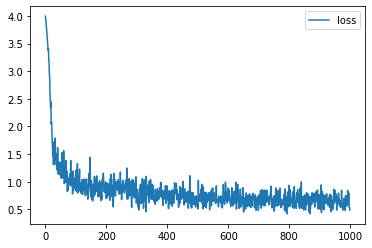

In [29]:
char_lstm_torch_rus = CharLSTMLoop(num_tokens=len(tokens_rus), embedding_size=16, rnn_num_units=64)
criterion_lstm_torch_rus = nn.NLLLoss()
opt_lstm_torch_rus = torch.optim.Adam(char_lstm_torch_rus.parameters())
train_modelRNN(char_lstm_torch_rus, opt_lstm_torch_rus, text_rus_splitChapter_torch, criterion_lstm_torch_rus,len(tokens_rus), n_iterations=1000, batch_size=16, exist_loop=True)

In [47]:
print("\n\nTEMP=0.1\n"+generate_sample(char_lstm_torch_rus,300 ,tokens_rus,token_to_idx_rus, seed_phrase="в поле ",temperature=0.1, exist_loop=True))
print("\n\nTEMP=0.2\n"+generate_sample(char_lstm_torch_rus,300 ,tokens_rus,token_to_idx_rus, seed_phrase="в поле ",temperature=0.2, exist_loop=True))
print("\n\nTEMP=0.3\n"+generate_sample(char_lstm_torch_rus,300 ,tokens_rus,token_to_idx_rus, seed_phrase="в поле ",temperature=0.3, exist_loop=True))
print("\n\nTEMP=0.4\n"+generate_sample(char_lstm_torch_rus,300 ,tokens_rus,token_to_idx_rus, seed_phrase="в поле ",temperature=0.4, exist_loop=True))
print("\n\nTEMP=0.5\n"+generate_sample(char_lstm_torch_rus,300 ,tokens_rus,token_to_idx_rus, seed_phrase="в поле ",temperature=0.5, exist_loop=True))
print("\n\nTEMP=0.6\n"+generate_sample(char_lstm_torch_rus,300 ,tokens_rus,token_to_idx_rus, seed_phrase="в поле ",temperature=0.6, exist_loop=True))
print("\n\nTEMP=0.7\n"+generate_sample(char_lstm_torch_rus,300 ,tokens_rus,token_to_idx_rus, seed_phrase="в поле ",temperature=0.7, exist_loop=True))
print("\n\nTEMP=0.8\n"+generate_sample(char_lstm_torch_rus,300 ,tokens_rus,token_to_idx_rus, seed_phrase="в поле ",temperature=0.8, exist_loop=True))
print("\n\nTEMP=0.9\n"+generate_sample(char_lstm_torch_rus,300 ,tokens_rus,token_to_idx_rus, seed_phrase="в поле ",temperature=0.9, exist_loop=True))
print("\n\nTEMP=1.0\n"+generate_sample(char_lstm_torch_rus,300 ,tokens_rus,token_to_idx_rus, seed_phrase="в поле ",temperature=1.0, exist_loop=True))
print("\n\nTEMP=2.0\n"+generate_sample(char_lstm_torch_rus,300 ,tokens_rus,token_to_idx_rus, seed_phrase="в поле ",temperature=2.0, exist_loop=True))



TEMP=0.1
в поле во поли пололи стелом
		и стели стели стели стели стала
		и столи во поле воло волом
		и стели стели стети стелоли,
		и поли стели стели стеле,
		и стели стели стете стели,
		и поли поло воло пололи,
		во поли воли стели стетали
		и стело во доли пололи стала
		и поло поли поли стелоло,
		и с


TEMP=0.2
в поле стели полови пололи
		и тет поли поли полово вололи
		и стело на поли столорана,
		и стеми столи на славе слави,
		сала ве поли стели порелом
		и стете во полово стели,
		и стели стети стом срали порави
		и поли стели поли стетом,
		во поли стели пололи стела
		и поло вело стем коли пололот
	


TEMP=0.3
в поле в пором волом тани коле,
		и ко поли стетил си ретела,
		и ве волы поломи стали,
		по воне сти порет на страла,
		и пода полет стрело воли порали
		поло восте во поретоло рамола.
		и стети во славо послем крат
		и порали стезам сорети вогол
		ве коло белон ве стели корав
		и б стели сконе пол


TEMP=0.4
в поле ко не воде волави
		и сте беми слато не нем ко

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch)